In [16]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline

# 0. Together
<img src="https://drive.google.com/uc?export=view&id=1qEgwsGeMTB7JwqGjMxeBeFKrlHch6Hqx" width=500px />


K-Means is an unsupervised ML algorithm. **Unsupervised ML** does not have "truth labels" for a model to learn. Rather, we use these algorithms to find what we call "latent structure" in our data. The most common form of "structure" we're looking for is groups (aka, clusters). 

K-means is one of the most simple clustering algorithms out there. You randomly (or, in order to make convergence quicker, cleverly) choose K centroids in the feature space, you assign each data point to the centroid/cluster closest to it, and then recalculate the centroid by taking the mean (for each predictor) of all the data points in each cluster. 

This process iteratively repeats until either 1) cluster assignments don't change from step to step OR 2) the centroid doesn't change much from step to step.

<img src="https://drive.google.com/uc?export=view&id=1RHRfcPIjIZ_-IMOE00gyzVadlaGxXPh8" width=350px />

One thing to keep in mind with K-Means is that is assumes *spherical* variance within each cluster. That means that K-means behaves as if--within each cluster--all predictors have the same variance. Because of this, it is often good to either check this assumption, or z-score your variables so that they're on the same scale.

## Super vs. Unsuper

### Supervised ML
Notice in the above code, our workflow is broadly:

1. load in data, create X's and y's
2. Set up Model Validation (TTS, KF, LOO...)
3. Z-score/transform our variables if needed.
4. Create Empty Model
5. Fit your model
6. Assess your model (using `.predict()` + some performance metric,  or `.score()`...)


The reason that we are SO CAREFUL about model validation (and related concerns like data leakage), is because in our dataset, we HAVE THE CORRECT ANSWERS. For the KNN model above, we knew the mode for each Beyonce song. This is because KNN is doing *Supervised* machine learning.

Supervised ML encompasses *predictive* models that we train using a dataset that has the correct values/labels.

*Unsupervised* ML is a little different...

### Unsupervised ML
In Unsupervised ML, we don't HAVE the "correct answers" for our model. Unsupervised ML focuses on finding underlying *structure* in the data, e.g. clusters. There's no "right" answer for these models. 

Because there isn't a "right" answer for us to compare our results to, we usually don't worry about Model Validation, nor do we care about data leakage. So our workflow is a little simpler.

1. load in our data
2. Scale data if needed
3. Create Empty Model
4. Fit your Model
5. Assess your model (using `.predict()` and by looking at plots, or something like a silhouette score)


Compare the KNN (Supervised) workflow to the KMeans (Unsupervised) workflow below:

In [17]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#### STEP 1. ####
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

#### STEP 2. ####
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#### STEP 3. ####
z = StandardScaler()

z.fit(X_train)
X_train[predictors] = z.transform(X_train)
X_test[predictors] = z.transform(X_test)

#### STEP 4. ####
# create model
knn = KNeighborsClassifier(5)

#### STEP 5. ####
knn.fit(X_train,y_train)

#### STEP 6. ####
print(accuracy_score(y_train, knn.predict(X_train)))
print(accuracy_score(y_test, knn.predict(X_test)))


0.8786279683377308
0.8210526315789474


0.3391679201309392


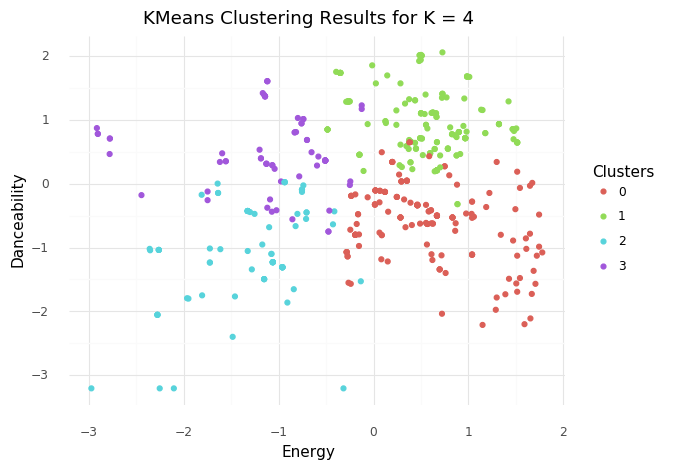

<ggplot: (8774479762776)>


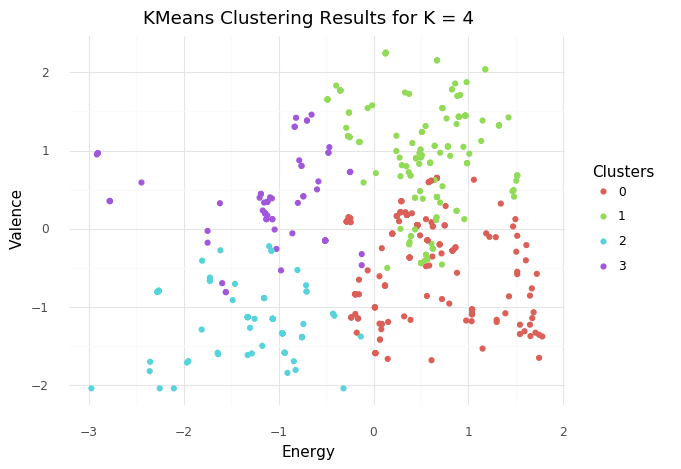

<ggplot: (8774479575263)>


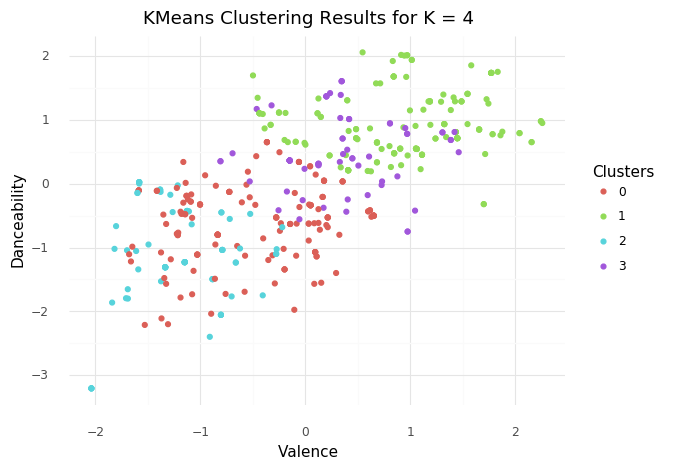

<ggplot: (8774480230129)>


In [18]:
#### STEP 1. ####
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

predictors = ["energy", "danceability", "valence"]


X = bey[predictors]

#### STEP 2. ####
z = StandardScaler()
X[predictors] = z.fit_transform(X)

#### STEP 3. ####
km = KMeans(n_clusters = 4)

#### STEP 4. ####
km.fit(X)

#### STEP 5. ####
print(silhouette_score(X, km.predict(X)))

X["clusters"] = km.predict(X)

print(ggplot(X, aes(x = "energy", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))
print(ggplot(X, aes(x = "energy", y = "valence", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Valence", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))
print(ggplot(X, aes(x = "valence", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Valence", y = "Danceability", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))


Notice that Model Validation isn't a part of our workflow anymore. Also notice that there are no `y` variables. When we `.fit()`, we only give it an `X`! This is all because KMeans is an *unsupervised* ML Algorithm.

# 1. K-Means Function

Let's write our own simplified K-means function. Your function, `KM()` should take in two arguments:

- `df` a dataframe with all of your data.
- `k` the number of clusters to fit.

and apply K-Means to it. Remember that the steps of K means are:

**1**. Randomly select k centroids.
- I recommend choosing `k` random data points from `df`. You can do this by using `np.random.choice(range(0,df.shape[0]), k)` to select the indices for `k` randomly selected rows. THEN use those indices to grab the chosen rows from df and store them.
    
**2**. Assign each data point from `df` to the closest centroid.
- You'll need to calculate the distance between each data point and each centroid. Perhaps look at the KNN classwork to see how to do that using `np.linalg.norm()` (see Hint 3).
    - I recommend storing cluster/centroid membership by having a dictionary with one key for each cluster/centroid, and the value is a list of row indices pertaining to the data points in each cluster (see HINT 1 for an example of this.
    
**3**. Re-calculate the cluster mean/centroid
- For each centroid/cluster, find the mean value for each predictor/feature by taking the mean for that feature from all the data points assigned to the centroid/cluster.(see Hint 2)
    
**4**. Repeat Steps 2-3 until the change in centroid positions are all less than 0.0001
- in other words, calculate how far each centroid moved. If all of them moved less than 0.0001 units, then stop.
    
**5**. Return the cluster assignments by returning the dictonary of the clusters and their memberships that you create in #2.

### HINT 1:

You can store your cluster memberships like this (in this case k = 3, and there are only 20 datapoints, but your function should take any k, and any number of data points):

```
clust = {"0": [0,7,4,5,12,18,20],
          "1": [10,8,3,2,14,17,19],
          "2": [1,6,7,9,11,13,15,16]}
```
      

### HINT 2:

If a cluster contained the following data points:

|           | X1 | X2 | X3 |
|-----------|----|----|----|
| Person 1  | 5  | 2  | 9  |
| Person 2  | 2  | 3  | 2  |
| Person 3  | 1  | 6  | 1  |
| Person 4  | 7  | 1  | 4  |
| Person 5  | 3  | 2  | 5  |
| Person 6  | 1  | 1  | 8  |
| Person 7  | 7  | 0  | 6  |
| Person 8  | 0  | 7  | 2  |
| Person 9  | 2  | 3  | 7  |
| Person 10 | 4  | 6  | 1  |


Then the centroid for that cluster would be [a,b,c] where a, b, and c are the means of each column X1, X2, and X3:

a = (5 + 2 + 1 + 7 + 3 + 1 + 7 + 0 + 2 + 4)/10 

b = (2 + 3 + 6 + 1 + 2 + 1 + 0 + 7 + 3 + 6)/10

c = (9 + 2 + 1 + 4 + 5 + 8 + 6 + 2 + 7 + 1)/10




### HINT 3:

To calculate the distance between two vectors, you can use:

```
distance_ab = np.linalg.norm(a-b)

```

where `a` and `b` are the two vectors.

### HINT 4:

The `np.argmin()` function takes in a list (or array) of values, and returns the *index* of the smallest one.

For example:

```
my_list = [1,6,2,5,0]

np.argmin(my_list)
```

this code would return 4, because the smallest value (0) in `my_list` is at index 4.

In [ ]:
def KM(df,k):
    
    # 1. randomly select k centroids
    
    ### YOUR CODE HERE ###-----------------------------------
    
    centroids = ### choose k random row indices from df,
    # then use those to grab the k data points and store
    # them in centroids. centroids should be a list of
    # rows (each row contains the data point you chose)
    # to be a cluster center
    
    ### /YOUR CODE HERE ###----------------------------------
    
    
    
    
    
    # 2. iterate through all the rows in df, calculate the distance
    # between that point and each centroid, and assign them to the
    # centroid closest to them, store those assignments in a dict

    converged = False # has the algorithm converged yet?
    
    while not converged: # until the centroids stop moving
        
        # add all the dictionary keys for each cluster
        # this makes a dictonary of lists, one key per
        # cluster
        # e.g. {'0': [], '1': [], '2': [], '3': [], '4': []}
        # if k = 5
        
        clust = {}
        for c in range(0,k):
            clust[str(c)] = []

        for dataPoint in range(0, df.shape[0]):
           
            # dataPoint is the *index* for each row, iteratively
            # calculate distances between df.iloc[dataPoint] and each centroid
            
            ### YOUR CODE HERE ###-----------------------------------
    
    
            ### /YOUR CODE HERE ###----------------------------------

        
            # find the centroid that's closest
            # hint: use np.argmin()
            
            ### YOUR CODE HERE ###-----------------------------------
    
    
            ### /YOUR CODE HERE ###----------------------------------

        
        
            # add dataPoint to that cluster in the clust dictionary
            
            ### YOUR CODE HERE ###-----------------------------------
    
    
            ### /YOUR CODE HERE ###----------------------------------

        
        
        
        
        
        # 3. re-calculate the center/centroid of each cluster

        new_centroids = [[] for c in range(0,k)] #create an empty list of k lists to fill in later

        for c in range(0,k): 
            # for each cluster calculate the new centroid values
            # hint: remember the new centroid value is the mean
            # (for each predicor) of data points in that cluster

            ### YOUR CODE HERE ###-----------------------------------
            # calculate the new centroids and add them to new_centroids
            
    
            ### /YOUR CODE HERE ###----------------------------------

        new_centroids = np.array(new_centroids) # change new centroids to be an array so that #4 works

        
        
        
        
        # 4. check whether you can stop iterating by checking whether the
        # distance between the previous position and current position is
        # less than 0.0001 for all k centroids.

        # calculate the distance between the old centroid values, and new_centroids values
        change = np.array([np.linalg.norm(centroids[i]-new_centroids[i]) for i in range(0,k)])
        
        # check whether all of them moved less than 0.0001 units.
        converged = np.all(change < 0.0001)

        # set new_centroids to be established centroids
        centroids = new_centroids


        
        
        
        
    # 5. Return cluster memberships dictionary, the structure
    # should look like this (but can have different k, and different
    # assignments depending on data/starting centroids/chosen )
    # {'0': [55, 72, 76, 85, 89, 93, 100, 104, 105, 107, 110, 119,
#          123, 132, 144, 201, 202, 203, 204, 205, 206, 207, 209,
#          210, 212, 213, 214, 215, 217, 218, 220, 221, 222, 223,
#          225, 226, 227, 228, 229, 231, 232, 233, 234, 237, 238,
#          241, 243, 245, 246, 247, 248, 249],
#     '1': [8, 47, 102, 103, 111, 114, 117, 120, 126, 129, 131, 136,
#          141, 142, 143, 145, 146, 148],
#     '2': [51, 101, 106, 108, 109, 112, 113, 115, 116, 118, 121,
#           122, 124, 125, 127, 128, 130, 133, 134, 135, 137, 138,
#           139, 140, 147, 149, 200, 219, 224, 230, 235, 239, 240,
#           242, 244],
#     '3': [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
#           161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
#           172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
#           183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
#           194, 195, 196, 197, 198, 199, 216, 236],
#     '4': [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16,
#           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
#           31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
#           45, 46, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61,
#           62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77,
#           78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 90, 91, 92, 94,
#           95, 96, 97, 98, 99, 208, 211]}
    return(clust)

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/programmers3.csv")

data.head()

# if you want to you can test your function on data!

# 2. Using your K-Means Function

Now that you have done the incredibly impressive work of writing (with some help!) your own K-means function. Let's use it and compare the results to what we'd get from `sklearn`!

First, use your OWN function `KM()` to do K-means on `data` with k = 5. Then generate the cluster assingments using the code provided. Then make a ggplot scatterplot of your clusters.

Second, use sklearn's `KMeans()` function to do K-means on `data` with k = 5. Then generate the cluster assignments using `.predict()`. Then make a ggplot scatterplot of your clusters.

In [ ]:
# USING YOUR FUNCTION-----

# run k-means using YOUR function

### YOUR CODE HERE ###-----------------------------------
clusters = ###
### /YOUR CODE HERE ###----------------------------------

# generate assignments
assignments = np.array([999 for row in range(0, data.shape[0])])

for cluster in clusters:
    assignments[clusters[cluster]] = cluster
    
data["assignments_ME"] = assignments

# create ggplot scatter plot of data, using x, y and color = "assignments_ME"
###

In [ ]:
# USING SKLEARN

# create kmeans model

### YOUR CODE HERE ###-----------------------------------

### /YOUR CODE HERE ###----------------------------------




# fit kmeans model

### YOUR CODE HERE ###-----------------------------------

### /YOUR CODE HERE ###----------------------------------




# get assignments

### YOUR CODE HERE ###-----------------------------------

assignments_SK = ###

### /YOUR CODE HERE ###----------------------------------


# add assignments to data
data["assignments_SK"] = assignments_SK

# create another ggplot scatter plot of data, using x, y and color = "assignments_SK"
### YOUR CODE HERE ###-----------------------------------

### /YOUR CODE HERE ###----------------------------------

### *Question*

How do your results compare?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />